In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import os, json
import matplotlib.pyplot as plt 
import matplotlib as mpl
%matplotlib inline 
import seaborn as sns
import scipy.stats as stats
from scipy.stats import norm
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

from sklearn.tree import export_graphviz 
import graphviz

from sklearn.metrics import confusion_matrix
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [2]:
data=pd.read_csv('data/bdata.csv') #for 54 files
#data=pd.read_csv('data/sdata.csv')
data=data.drop(['Unnamed: 0'],axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171612 entries, 0 to 171611
Data columns (total 61 columns):
creator_name                               171611 non-null object
name                                       171612 non-null object
creator_id                                 171612 non-null int64
backers_count                              171612 non-null int64
blurb                                      171612 non-null object
is_starred                                 171612 non-null bool
category.id                                171612 non-null int64
category.name                              171612 non-null object
category.parent_id                         171612 non-null float64
category.slug                              171612 non-null object
country                                    171612 non-null object
currency                                   171612 non-null object
goal                                       171612 non-null float64
staff_pick                        

# word cloud

In [3]:

def show_wordcloud(data, title = None):
    '''Split names by space and generate word counts.'''
    wordcloud = WordCloud(
        background_color='white',
        max_words=100,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

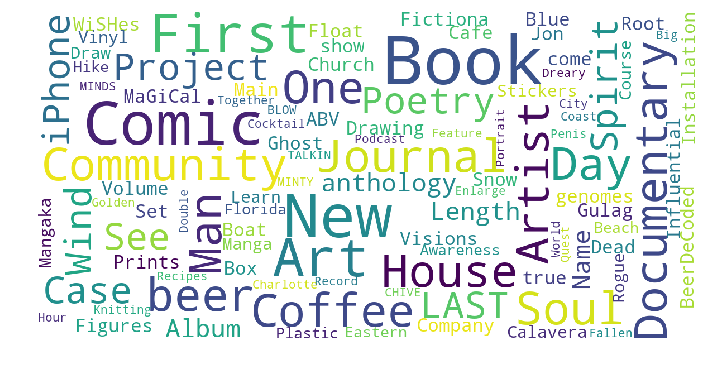

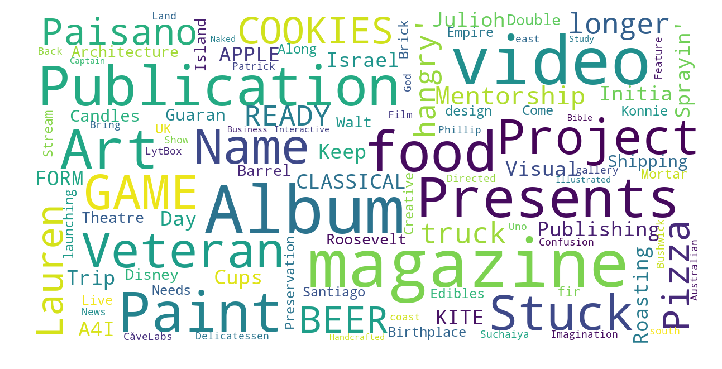

In [4]:
show_wordcloud(data[data.state == 'successful']['name'])
show_wordcloud(data[data.state == 'failed']['name'])

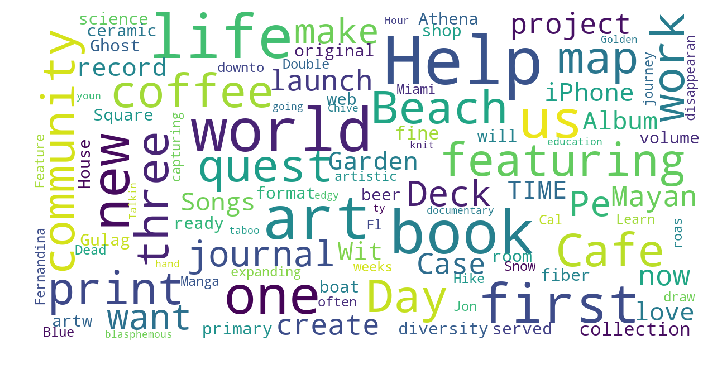

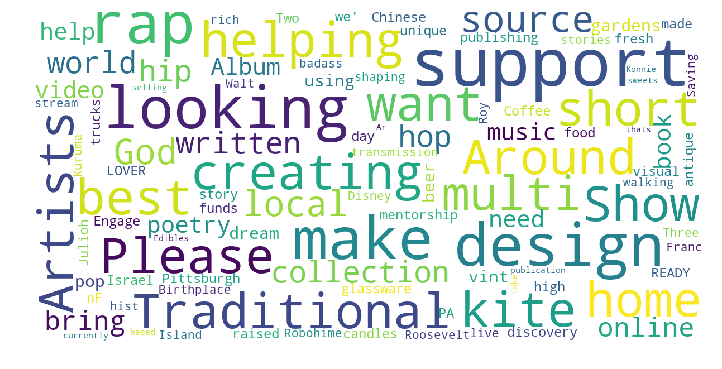

In [5]:
show_wordcloud(data[data.state == 'successful']['blurb'])
show_wordcloud(data[data.state == 'failed']['blurb'])

In [6]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image    # to import the image
 
# Create a list of word (https://en.wikipedia.org/wiki/Data_visualization)
 
# Load the image (http://python-graph-gallery.com/wp-content/uploads/wave.jpg)
wave_mask = np.array(Image.open( "down.png"))
 
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(mask=wave_mask,max_font_size=43,background_color='white').generate(str(data))
    plt.figure(figsize=(10,8),facecolor = 'white', edgecolor='red')
    plt.imshow(wordcloud.recolor(colormap='Reds'), interpolation="bilinear",)
    plt.axis("off")
    plt.margins(x=0, y=0)

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)
    


show_wordcloud(data[data.state == 'failed']['name'])

FileNotFoundError: [Errno 2] No such file or directory: 'down.png'

In [7]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image    # to import the image
 
# Create a list of word (https://en.wikipedia.org/wiki/Data_visualization)
 
# Load the image (http://python-graph-gallery.com/wp-content/uploads/wave.jpg)
wave_mask = np.array(Image.open( "up.jpg"))
 
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(mask=wave_mask,max_font_size=48,background_color='white').generate(str(data))
    plt.figure(figsize=(10,8),facecolor = 'white', edgecolor='blue')
    plt.imshow(wordcloud.recolor(colormap='YlGn'), interpolation="bilinear",)
    plt.axis("off")
    plt.margins(x=0, y=0)

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    #plt.show()
    
show_wordcloud(data[data.state == 'successful']['name'])


FileNotFoundError: [Errno 2] No such file or directory: 'up.jpg'

In [33]:
word=data[['state_num','name_len','name_is_question','name_is_exclamation','name_is_upper','name_non_character','name_number_of_word','name_vowel_ratio','blurb_number_of_word','blurb_vowel_ratio','blurb_non_character']]
corr_word=word.corr()
corr_word=corr_word.loc['state_num']
corr_word.nlargest(12)

state_num               1.000000
name_non_character      0.153215
name_number_of_word     0.144058
name_len                0.124519
name_is_exclamation     0.048826
blurb_non_character     0.038614
blurb_number_of_word    0.003242
blurb_vowel_ratio       0.003242
name_is_question       -0.003326
name_vowel_ratio       -0.014961
name_is_upper          -0.015229
Name: state_num, dtype: float64

In [15]:
word_m=word.loc[word['state_num']==1]
word_m=word_m.mean()
word_m

state_num                1.000000
name_len                36.671157
name_is_question         0.003290
name_is_exclamation      0.091198
name_is_upper            0.033728
name_non_character       6.736494
name_number_of_word      6.104812
name_vowel_ratio         0.309924
blurb_number_of_word    19.428802
blurb_vowel_ratio       19.428802
blurb_non_character     22.716874
dtype: float64

In [10]:
word_m=word.loc[word['state_num']==0]
word_m=word_m.mean()
word_m

state_num                0.000000
name_len                32.681248
name_is_question         0.003685
name_is_exclamation      0.064522
name_is_upper            0.039469
name_non_character       5.542952
name_number_of_word      5.299427
name_vowel_ratio         0.312575
blurb_number_of_word    19.396614
blurb_vowel_ratio       19.396614
blurb_non_character     22.224550
dtype: float64

In [11]:
word_m=word
word_m=word_m.mean()
word_m

state_num                0.566685
name_len                34.942271
name_is_question         0.003461
name_is_exclamation      0.079639
name_is_upper            0.036215
name_non_character       6.219315
name_number_of_word      5.755827
name_vowel_ratio         0.311073
blurb_number_of_word    19.414854
blurb_vowel_ratio       19.414854
blurb_non_character     22.503543
dtype: float64

In [25]:
corr_df=data.corr()
cor_st=corr_df.loc['state_num']
print(cor_st.nsmallest())
print(cor_st.nlargest())

category.id          -0.335087
deadline_yr          -0.201259
created_at_yr        -0.199914
launched_at_yr       -0.198035
category.slug_food   -0.165347
Name: state_num, dtype: float64
state_num              1.000000
success                1.000000
staff_pick             0.272324
name_non_character     0.148786
name_number_of_word    0.144489
Name: state_num, dtype: float64


## Data visualization

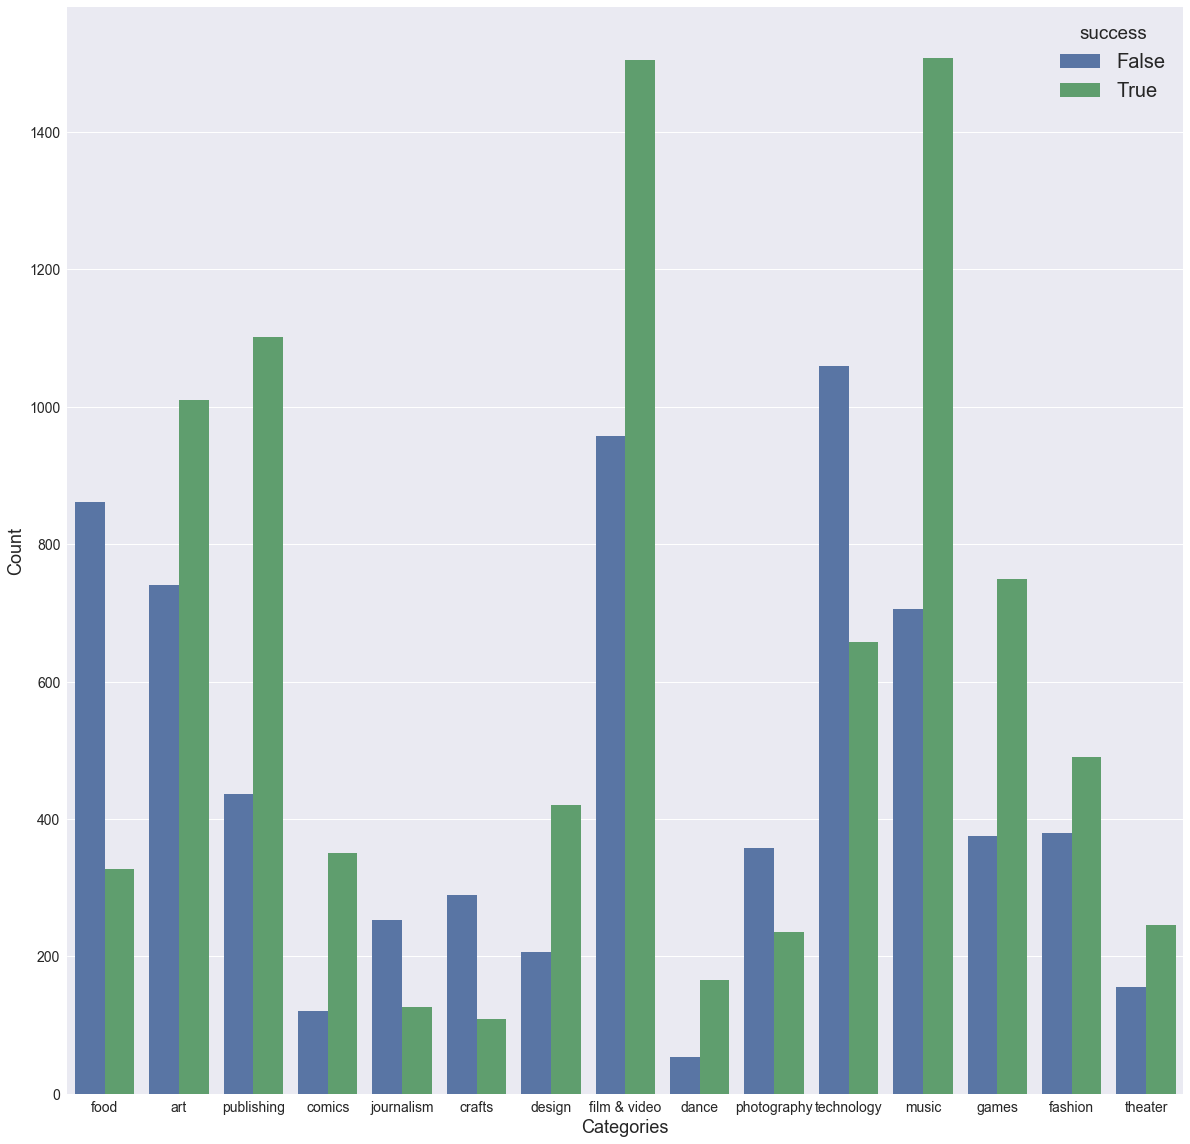

In [31]:
from seaborn import set
plt.rcParams['figure.figsize']=(20,20)
set(font_scale=2)
b=sns.countplot(x='category.slug', hue='success',data=data)
b.set_xlabel("Categories",fontsize=18)
b.set_ylabel("Count",fontsize=18)
b.tick_params(labelsize=14)

Text(0,0.5,'Count')

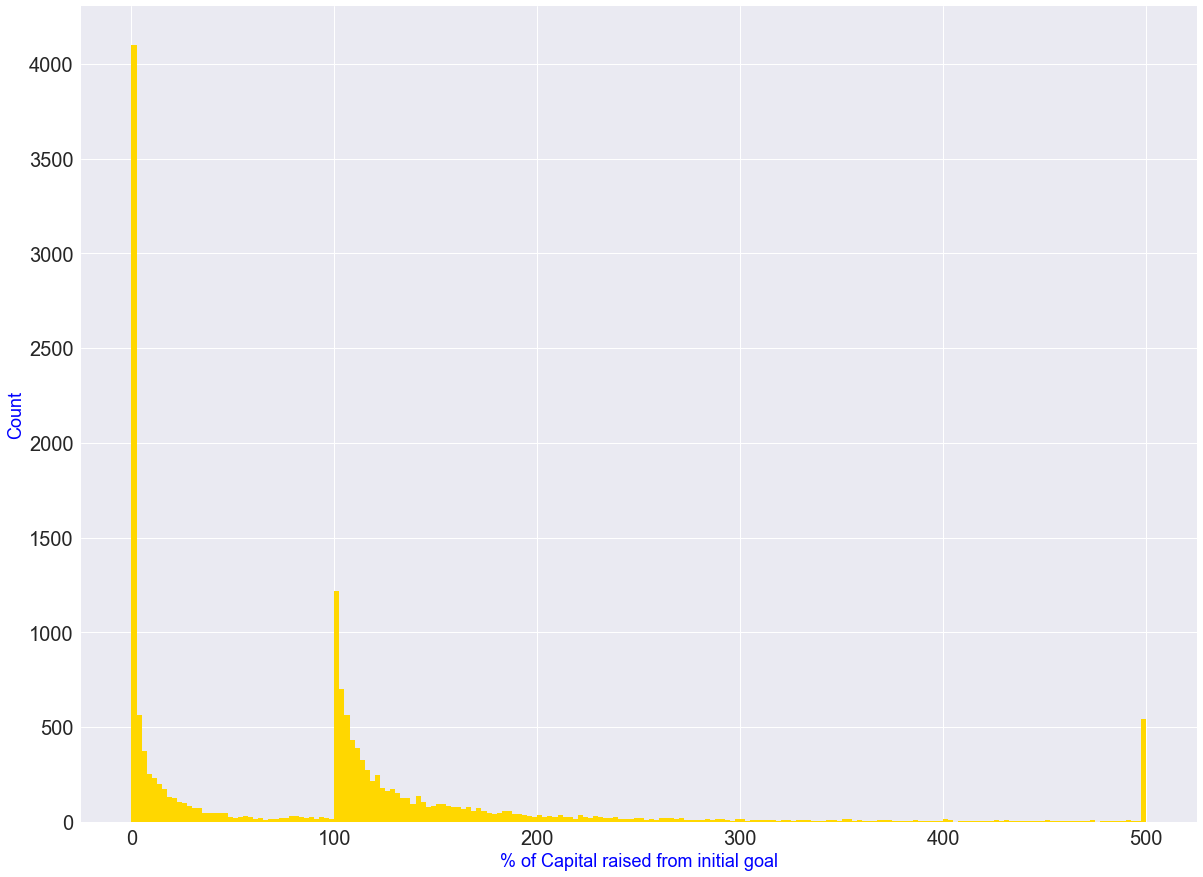

In [32]:
PP=np.clip(data['pledge_perc'], 0, 500)
fig=PP.hist(bins = 200, figsize = (20,15),color='gold')
fig.set_xlabel("% of Capital raised from initial goal",fontsize=18,color='b')
fig.set_ylabel("Count",fontsize=18,color='b')



In [33]:
corr_matrix = data.corr()
corr_matrix["success"].sort_values()

category.id                -0.335087
deadline_yr                -0.201259
created_at_yr              -0.199914
launched_at_yr             -0.198035
deadline-launched          -0.083001
goal_1000                  -0.082135
goal_500                   -0.082034
goal_10                    -0.081988
goal                       -0.081988
deadline_hr                -0.062170
category.parent_id         -0.052169
created_at_mo              -0.026364
deadline_day_in_month      -0.015655
launched_at_day_in_month   -0.015207
launched_at_mo             -0.014790
name_is_upper              -0.013175
name_is_question           -0.012906
deadline_day_in_week       -0.011504
deadline_mo                -0.009745
launched_at_hr             -0.009481
launched_at_day_in_week    -0.005620
created_at_day_in_week     -0.005002
created_at_day_in_month    -0.004577
name_vowel_ratio           -0.004272
Unnamed: 0.1               -0.000519
creator_id                  0.000831
blurb_vowel_ratio           0.005940
b

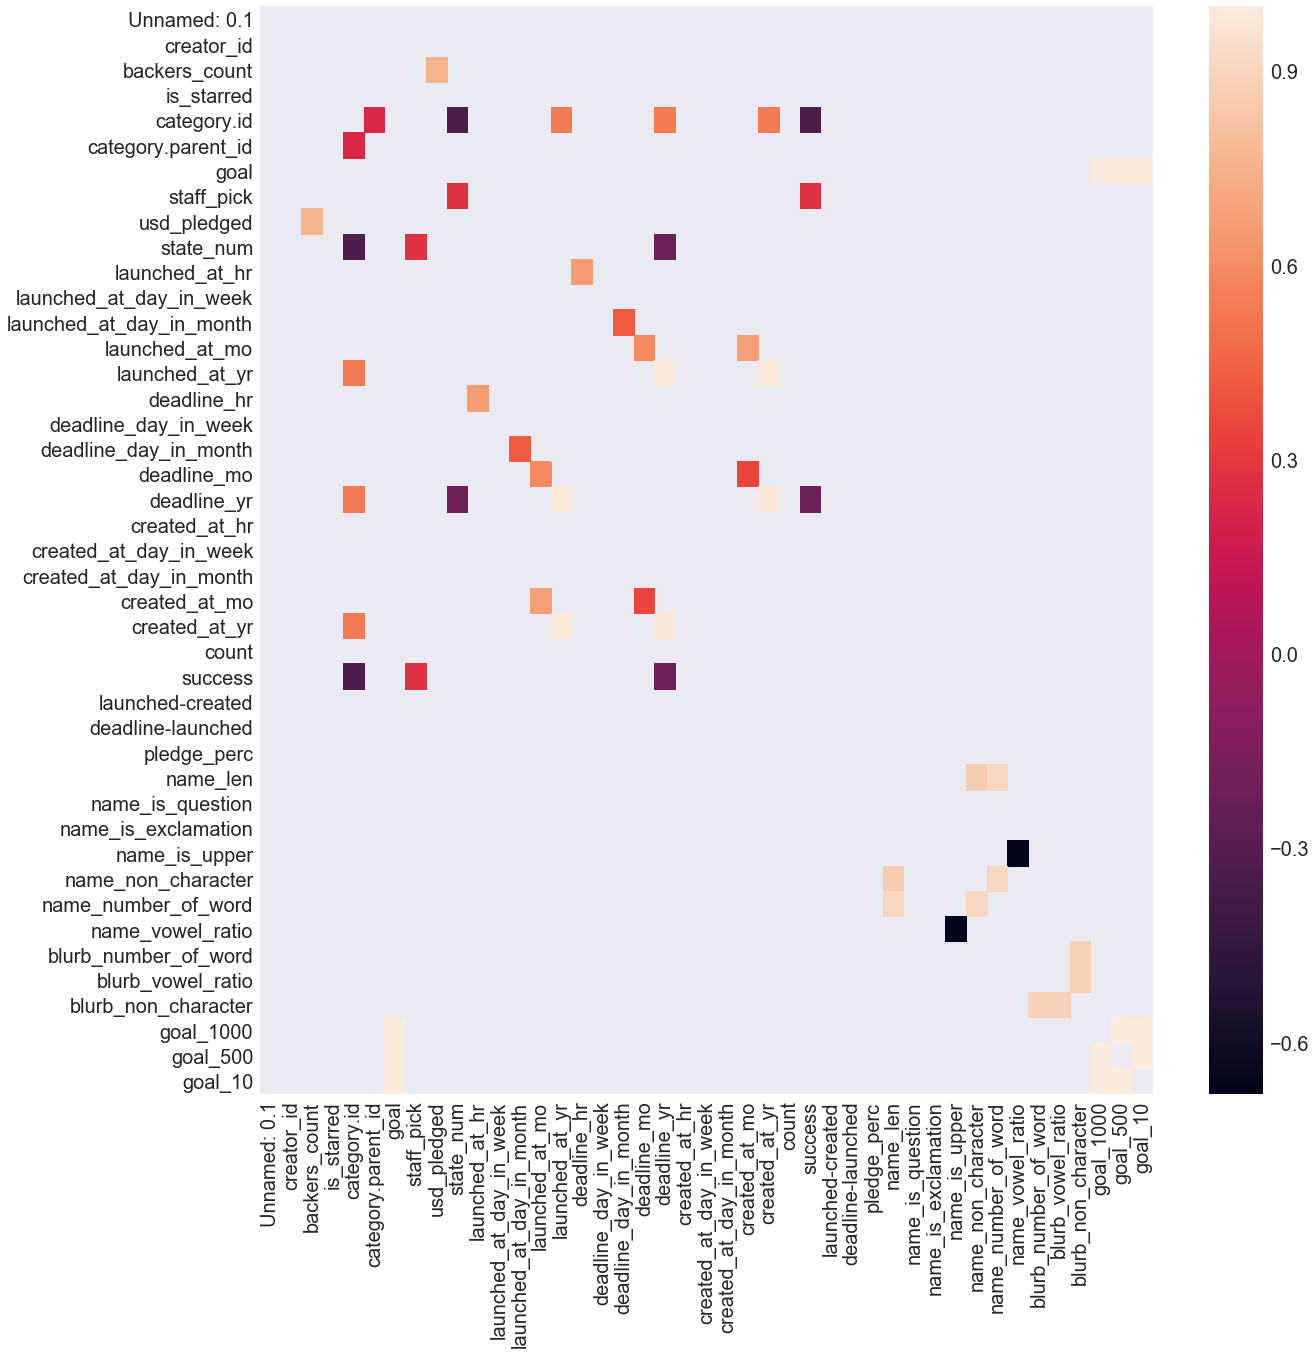

In [34]:
sns.heatmap(corr_matrix[(corr_matrix<1) & ((corr_matrix >= 0.2) | (corr_matrix <= -0.2)) ] )

Text(0,0.5,'USD Pledged')

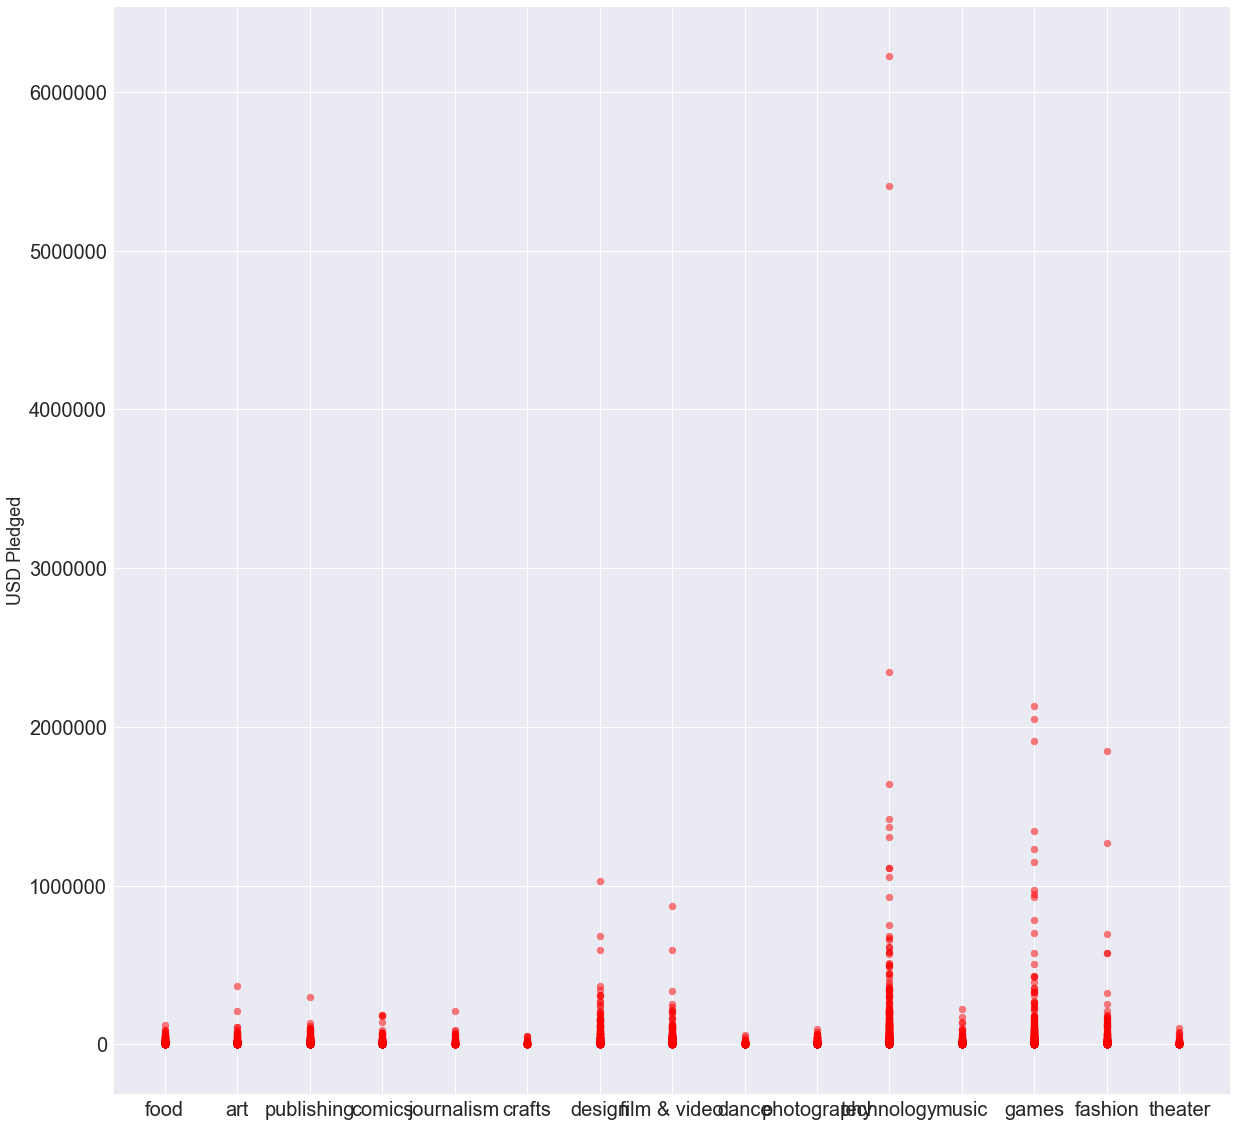

In [35]:
plt.scatter(x='category.slug', y='usd_pledged', data=data, alpha=0.5, color='r')
plt.ylabel("USD Pledged",fontsize=18)

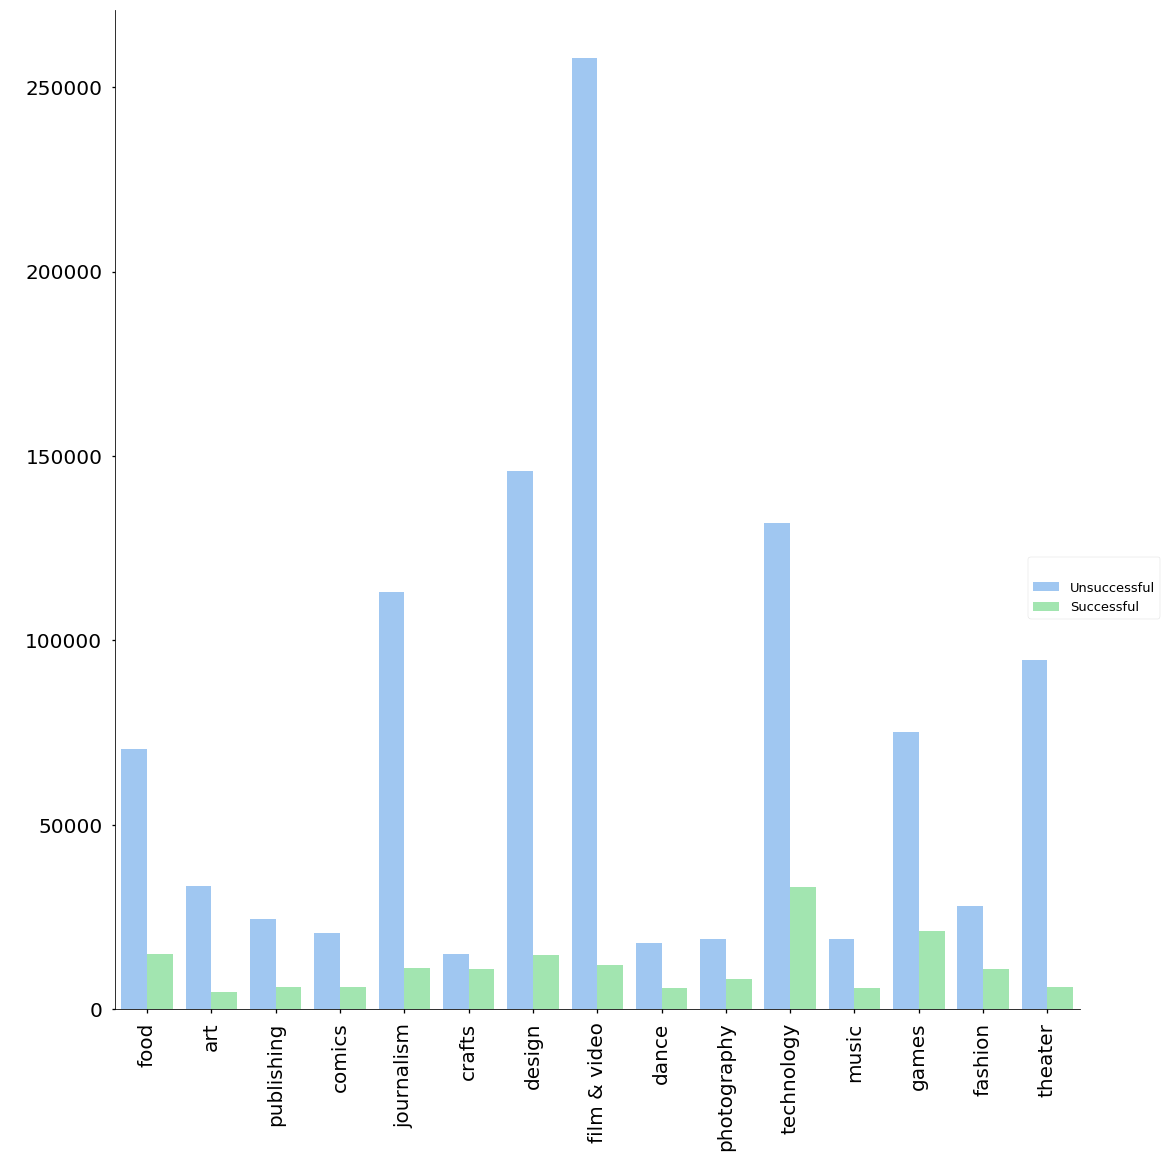

In [58]:
g= sns.factorplot(x='category.slug', y='goal', hue='state_num', palette="pastel", kind='bar', ci= None, data=data, size=15)
#g.set_axis_labels('Category','Goal')
g.set_axis_labels(' ',' ')
# title
new_title = ' '
g._legend.set_title(new_title)
# replace labels
new_labels = ['Unsuccessful', 'Successful']
for t, l in zip(g._legend.texts, new_labels): t.set_text(l)
#g.ax(loc='upper right', bbox_to_anchor=(0, 1.1))
locs, labels = plt.xticks();
plt.setp(labels, rotation=90);
#plt.title('Range of goal ($) among successful and failed projects')

plt.gca().set_yscale("linear", nonposy='clip');
sns.set_context(font_scale=3);
g.set_xticklabels(fontsize=20)
g.set_yticklabels(fontsize=20)
#מראה את הצלחת הפרויקטים לפי סכום היעד לגיוס- רואים שבגדול פרויקטים שנכשלו ביקשו יותר מדי. מצד שני רואים (טבלה הבאה) שפרויקטים שהצליחו לרב יגייסו 150%

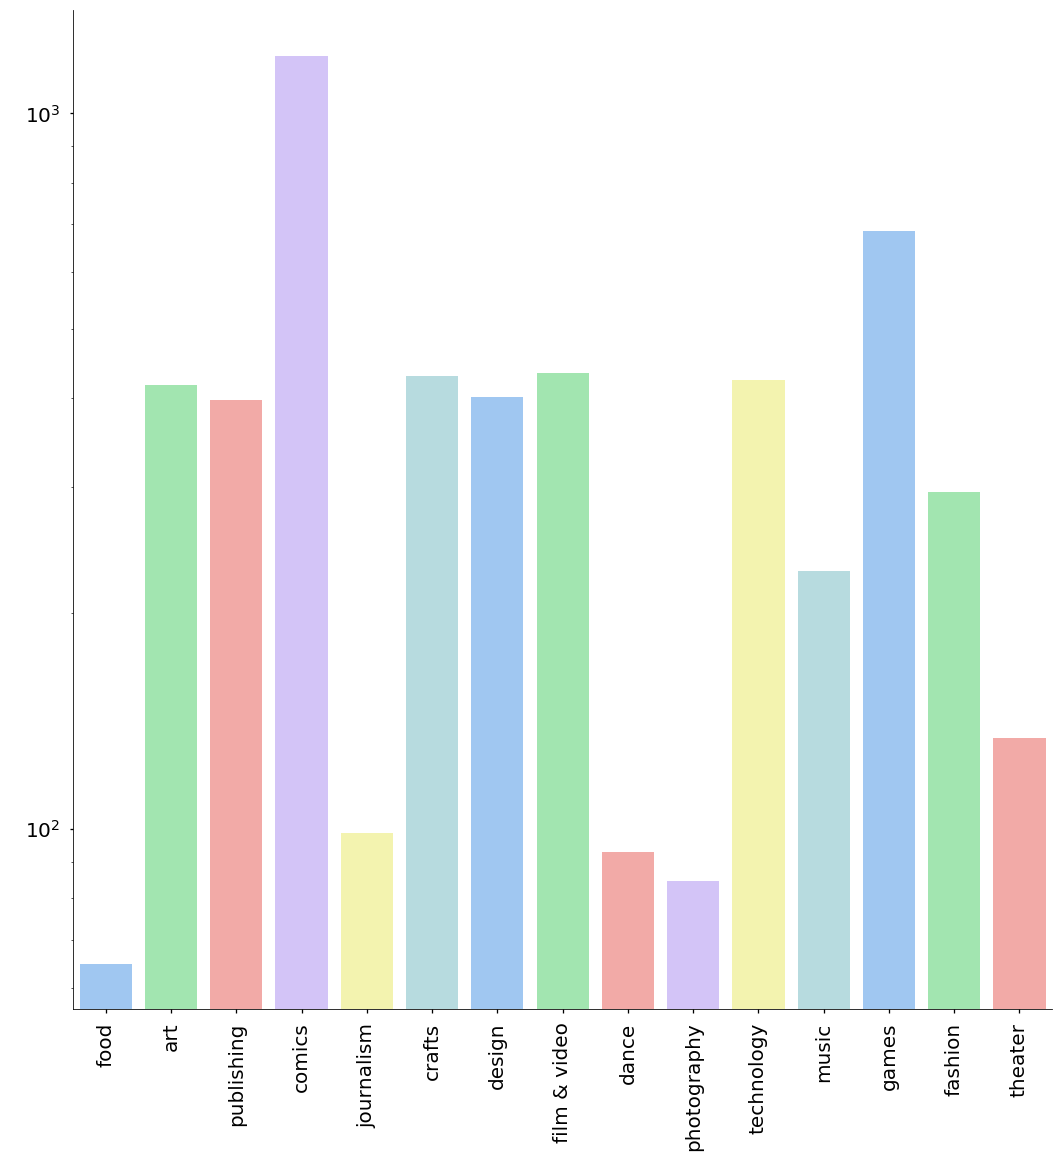

In [61]:
df_suc=data.loc[data['state_num']==1]
ax=sns.factorplot(x='category.slug', y='pledge_perc', kind='bar',palette="pastel", ci= None ,data=data, size=15)
locs, labels = plt.xticks();
plt.setp(labels, rotation=90);
ax.set_axis_labels(' ',' ')
ax.set_xticklabels(fontsize=20)
ax.set_yticklabels(fontsize=20)
#plt.title('Pledge % (log) Among Successful Projects')
plt.gca().set_yscale("log", nonposy='clip');
#מה אחוז הגיוס מתוך פריקטים שהצליחו. רואים שניתן לגייס ''פחות'' אבל בפועל יצא יותר

In [38]:
print('Average pledge % per category')
df_suc.groupby('category.slug', as_index=False, sort=False)['pledge_perc'].mean()

Average pledge % per category


,category.slug,pledge_perc
0,art,246.177393
1,food,512.525496
2,publishing,183.133184
3,comics,697.460481
4,journalism,136.455552
5,design,329.647398
6,film & video,1389.244526
7,dance,120.897716
8,photography,185.243332
9,technology,5079.197053


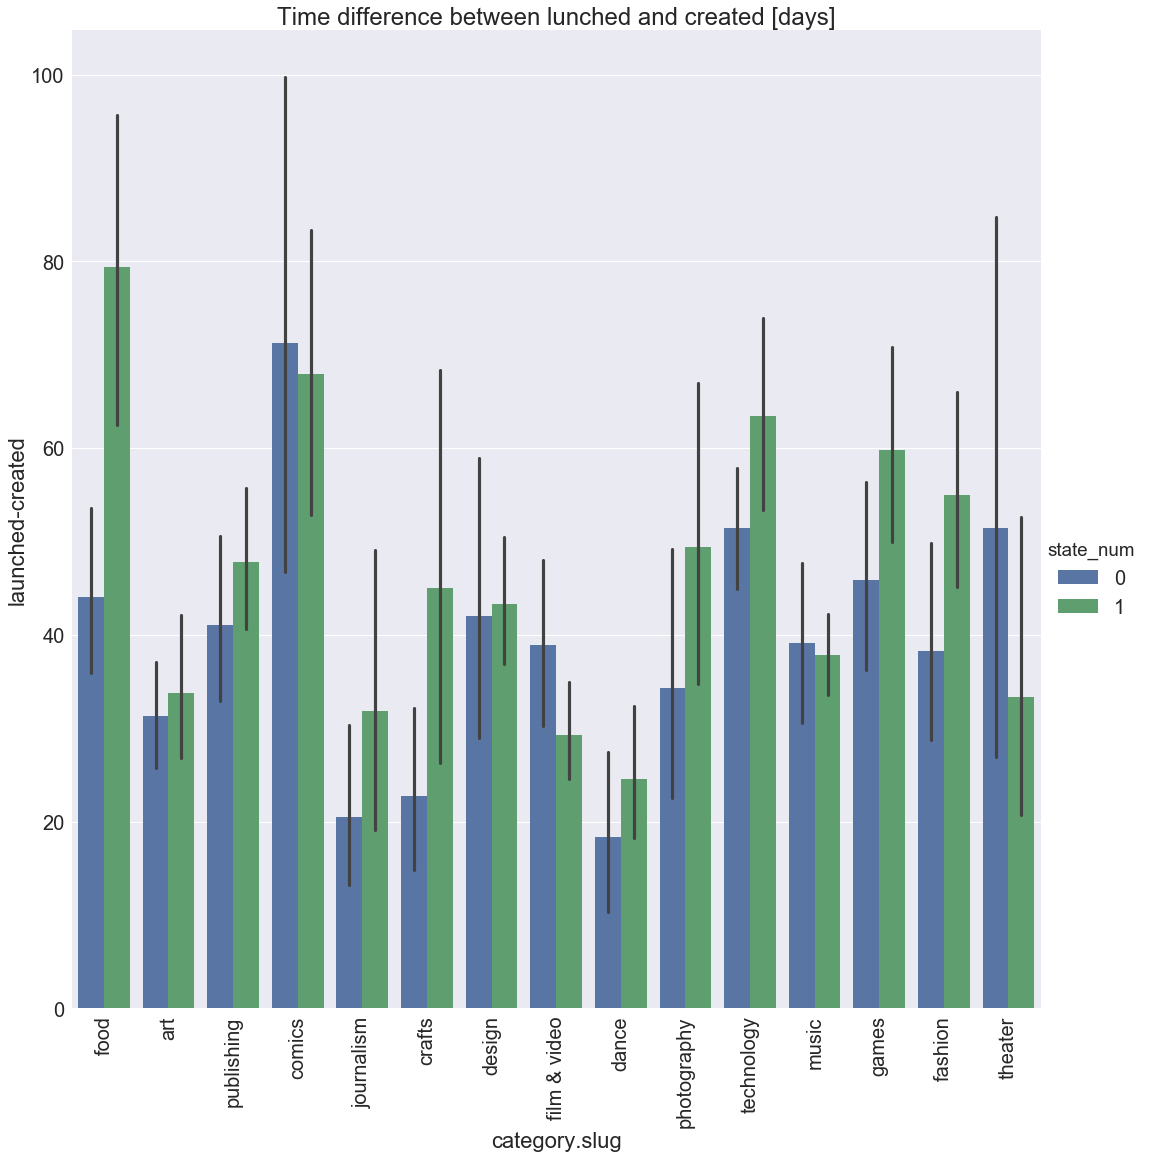

In [39]:
sns.factorplot(x='category.slug', y='launched-created', hue='state_num', kind='bar', data=data, size=15)
locs, labels = plt.xticks();
plt.setp(labels, rotation=90);
plt.title('Time difference between lunched and created [days]')
plt.gca().set_yscale("linear", nonposy='clip');
#כמעט תמיד עדיף להשיק אחרי שהקמפייין ''מתבשל'' קצת. חריגים הם הקולנוע והתיאטרון

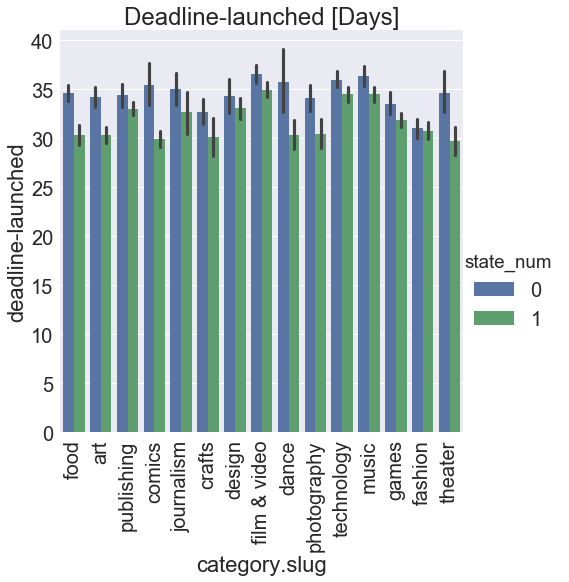

In [40]:
sns.factorplot(x='category.slug', y='deadline-launched', hue='state_num', kind='bar', data=data, size=7)
locs, labels = plt.xticks();
plt.setp(labels, rotation=90);
plt.title('Deadline-launched [Days]')
plt.gca().set_yscale("linear", nonposy='clip');
#נתון כנראה לא רלוונטי

# money waste on unsuccessful camp 

In [13]:
df_unsuc=data.loc[data['state_num']==1]
waste = df_unsuc['usd_pledged'].sum()
waste

2113695556.5591686

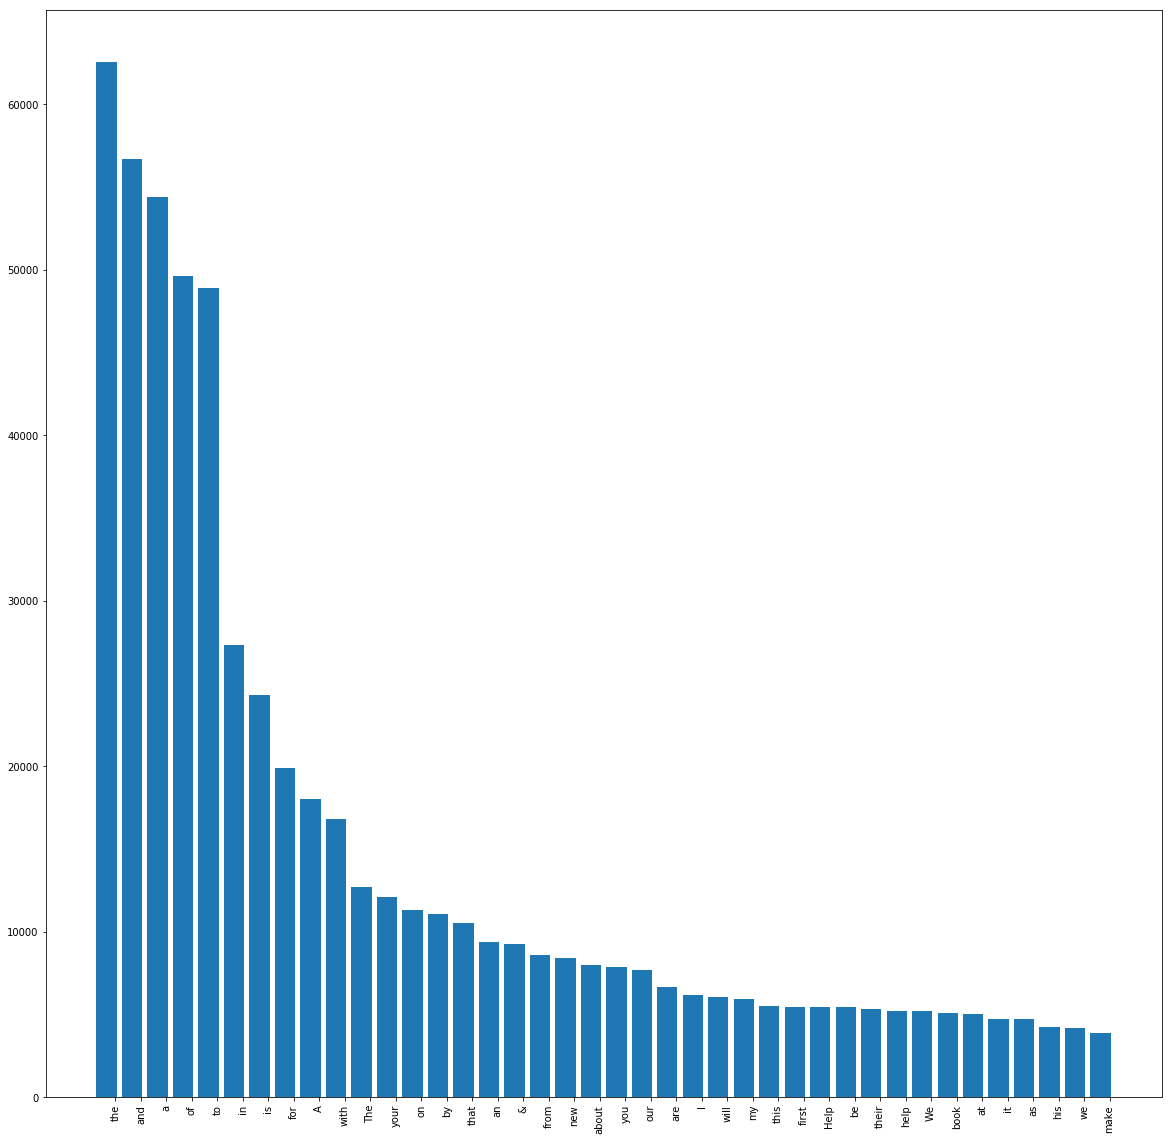

In [42]:
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

Words=' '.join(data[data.state == 'successful']['blurb'])

wordlist = Words.split()

#counts = Counter(word_list)
counts = dict(Counter(wordlist).most_common(40))
labels, values = zip(*counts.items())

# sort your values in descending order
indSort = np.argsort(values)[::-1]

# rearrange your data
labels = np.array(labels)[indSort]
values = np.array(values)[indSort]

indexes = np.arange(len(labels))

bar_width = 0.35
plt.figure(figsize=(20,20))
plt.bar(indexes, values)

# add labels
plt.xticks(indexes + bar_width, labels,rotation=90)
#plt.setp(labels, rotation=90)
plt.show()

In [39]:
print (labels[0:100])

['the' 'and' 'a' 'of' 'to' 'in' 'is' 'for' 'A' 'with' 'The' 'your' 'on'
 'by' 'that' 'an' '&' 'from' 'new' 'about' 'you' 'our' 'are' 'I' 'will'
 'my' 'this' 'first' 'be' 'Help' 'their' 'help' 'We' 'book' 'at' 'it' 'as'
 'his' 'we' 'make' 'film' 'us' 'album' 'into' 'all' 'This' 'need' '-' 'who'
 'art' 'music' 'An' 'can' 'have' 'get' 'her' 'story' 'one' 'game' 'or'
 'through' 'world' 'short' 'project' 'record' 'out' 'has' 'series' 'life'
 'create' 'love' 'up' 'want' 'original' 'more' 'but' 'two' 'New'
 'featuring' 'recording' 'me' 'bring' 'young' 'set' 'made' 'people' 'time'
 'based' "I'm" 'making' 'full' 'inspired' 'they' 'like' 'some' 'unique'
 'most' 'part' 'collection' 'fund']
